# Goals

This is where the actual data analysis happens. "VizualizeData.ipynb" is where I actually go about parsing the data which I then put into usable data files so I don't need to re-parse each time.

In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits

### Load data

In [2]:
### Load data from my data files ###

## C20 phot data:
c20p_all = np.load("Data/Hyperion_C20_phot.npy", allow_pickle=True)

## C20 spec data:
c20s_all = np.loadtxt("Data/Hyperion_C20_spec.txt", dtype=str, skiprows=1)


# Fix up the formatting for the spec data-file:
new_array = []
c20s_all = c20s_all.astype(object)
for idx in range(c20s_all.shape[1]):
    try:
        col = c20s_all[:,idx].astype(np.float32)
    except:

        col = c20s_all[:,idx]
    new_array.append(col)

c20s_all = np.array(new_array, dtype=object)
c20s_all = np.transpose(c20s_all)

### Data Cuts

In [3]:
### Defining Boundaries of Hyperion ###

ra_range = (149.6, 150.52)
dec_range = (1.74, 2.73)
z_range = (2.35, 2.55)

IRAC_lim = 25.4

In [4]:
### CUT OUT BAD GALAXIES ###

## C20 Spectra
spec_ids = np.where((c20s_all[:,11] >= z_range[0]) & (c20s_all[:,11] <= z_range[1])
                & (c20s_all[:,4] >= ra_range[0]) & (c20s_all[:,4] <= ra_range[1])
                & (c20s_all[:,6] >= dec_range[0]) & (c20s_all[:,6] <= dec_range[1]) )

c20s = c20s_all[spec_ids]

## C20 phot
phot_ids = np.where((c20p_all["lp_zPDF"] >= z_range[0]) & (c20p_all["lp_zPDF"] <= z_range[1])
                & (c20p_all["ALPHA_J2000"] >= ra_range[0]) & (c20p_all["ALPHA_J2000"] <= ra_range[1])
                & (c20p_all["DELTA_J2000"] >= dec_range[0]) & (c20p_all["DELTA_J2000"] <= dec_range[1]) 
                & (c20p_all["IRAC_CH1_MAG"] <= IRAC_lim))

c20p = c20p_all[phot_ids]

---
---
---


# Peaks

For each sigma-threshold, I'll make a plot of the location of the peaks in Hyperion

In [5]:
### IMPORT OD DATA ###

## Interpolated sigma cube
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

## Path for folders with .dat sigma files
sigPath = r"HyperionPeaks"

### Sigma-file Data description

0. Smoothed grid of the interpolated densities for each redshift (z, dec, RA)
1. 1D array of RA
2. 1D array of Dec
3. 1D array of avg z for each slice
4. 1D array of min z for each slice
5. 1D array of max z for each slice
6. mean density as fn of z
7. mean overdensity as fn of z
8. std dev of overdensity as fn of z
9. 2nd-order poly fit of (7)
10. 2nd-order poly fit of (8)
11. 5th-order poly fit of (7)
12. 5th-order poly fit of (8)

where "overdensity" $\log(1+\delta_{gal})$ is given by:
$$
\log(1+\delta_{gal}) = \frac{\Sigma}{\bar{\Sigma}}
$$

In [6]:
style_dict = {
    12: ['*', 'red', "[12,12.5)"], 
    12.5: ['h', 'gold', "[12.5,13)"], 
    13: ['o', 'deepskyblue', "[13,13.5)"], 
    13.5: ['X', 'darkorange', "[13.5,14)"], 
    14 :['>', 'forestgreen', "[14,14.5)"], 
    14.5 : ['s', 'royalblue', "[14.5,15)"], 
    15 :['D', 'maroon', "M >=15"]
}

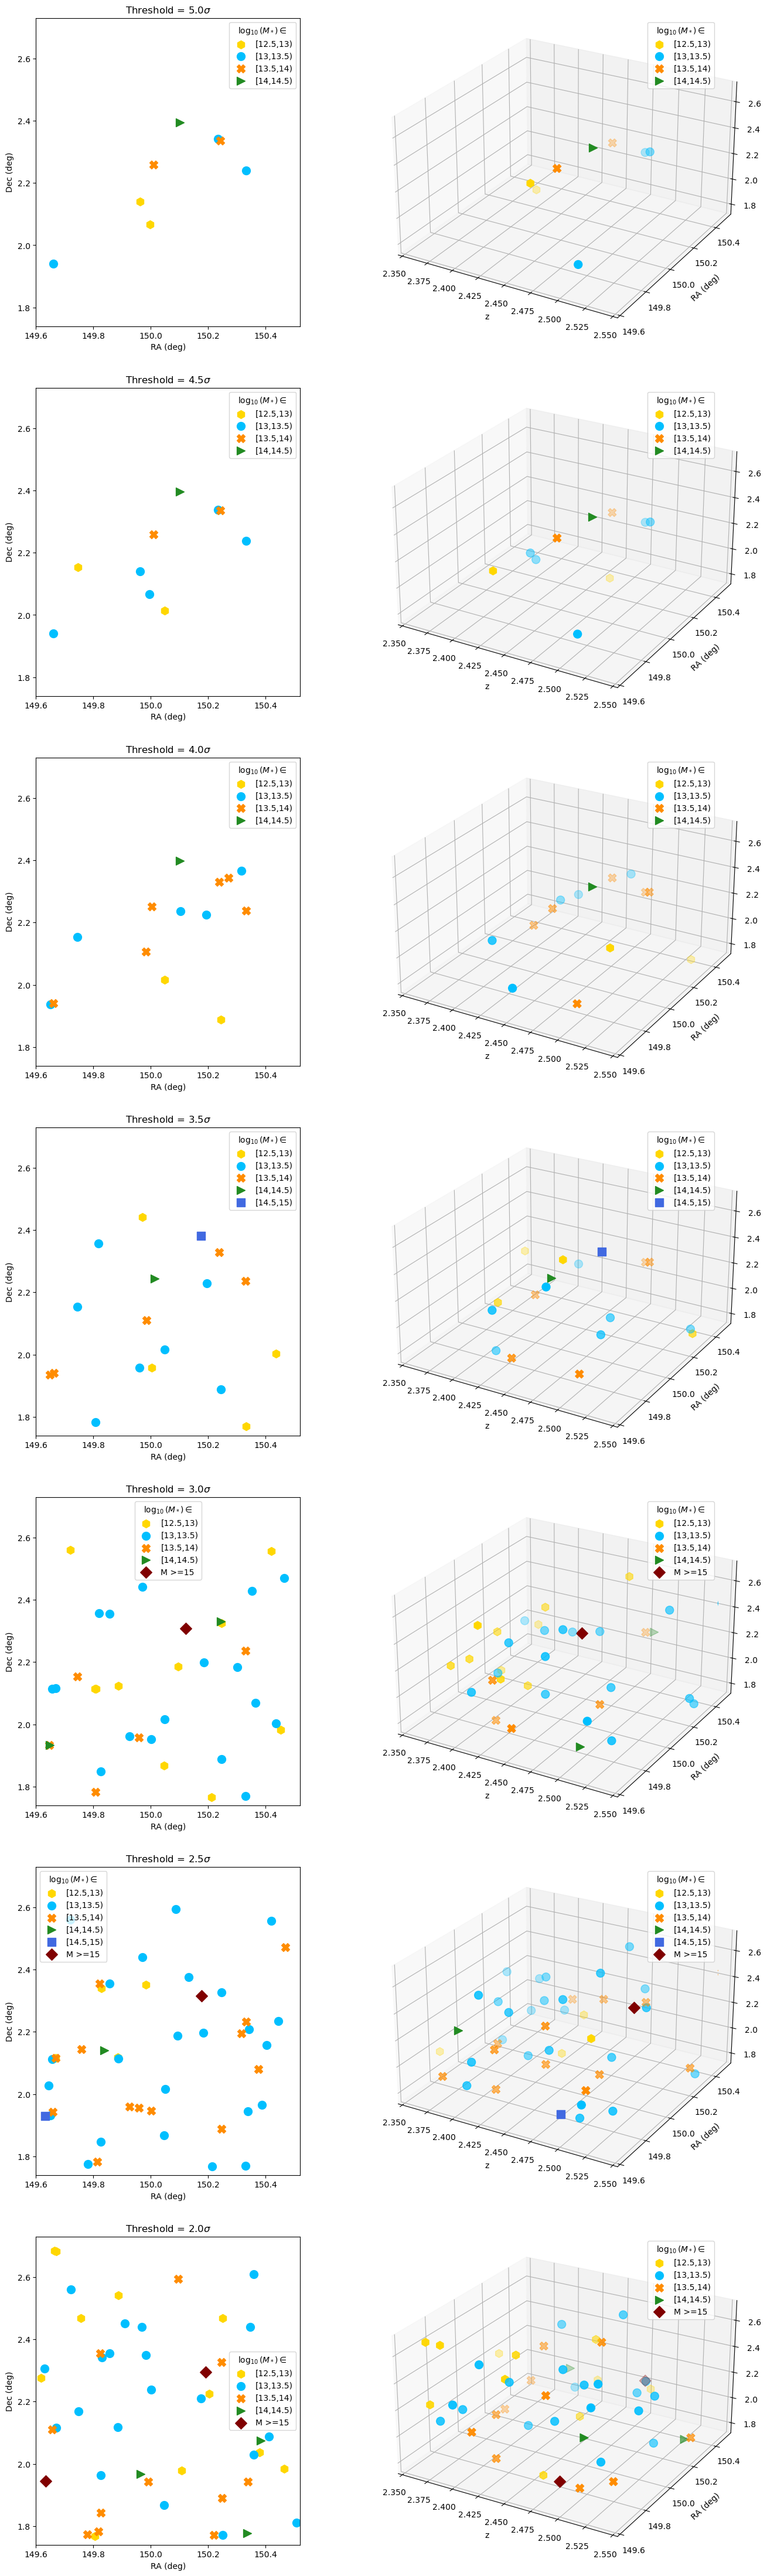

In [7]:
### PLOT LOCATIONS ###

sigs = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]

# --------------------------------------------------------------

fig = plt.figure(figsize=(16,8*len(sigs)))
gs = gridspec.GridSpec(len(sigs), 1, wspace=0)

peak_vols = []      # Used later

for idx, s in enumerate(sigs):

    # Read in the summary file
    # sig_sum = np.genfromtxt(f"HyperionPeaks\peaks_sig{s}.dat", dtype=float, skip_header=0)    # use original summary files
    sig_sum = np.genfromtxt(f"HyperionPeaks_new\peaks_sig{s}.dat", dtype=float, skip_header=0)    # use new summary files


    # Find the interpolated position of each peak barycenter
    RAs = np.interp(x = sig_sum[:,4], xp = np.arange(np.shape(sig_cube[1])[0]), fp = sig_cube[1].data)
    decs = np.interp(x = sig_sum[:,5], xp = np.arange(np.shape(sig_cube[2])[0]), fp = sig_cube[2].data)
    zs = np.interp(x = sig_sum[:,6], xp = np.arange(np.shape(sig_cube[3])[0]), fp = sig_cube[3].data)

    bc_coords = np.c_[RAs, np.c_[decs, zs]]  # Make a list of the (RA, dec, z) of each peak barycenter
    pk_ms = sig_sum[:,11]       # Mass of each peak
    # vols = sig_sum[:,10]        # Volume of each peak from find_peaks
    vols = sig_sum[:,-2]

    # Make a cut for RA, dec, z, and masses to sort the peaks
    g_idxs = np.where(  (RAs >= ra_range[0]) & (RAs <= ra_range[1])     # RAs
                & (decs >= dec_range[0]) & (decs <= dec_range[1])       # Decs
                & (zs >= z_range[0]) & (zs <= z_range[1])       # redshifts
                & (pk_ms >= 12.8)    )                      # Masses

    g_coords = bc_coords[g_idxs]
    g_ms = pk_ms[g_idxs]
    g_vols = vols[g_idxs]

    round_ms = np.array([min(15,m//0.5/2) for m in g_ms])       # Fill with the rounded masses that dicate the plotting style
    peak_vols.append(sum(g_vols))   # Add total volume of good peaks for a given sigma

    ## PLOT
    row = gs[idx].subgridspec(1,2, width_ratios=[1,1.5])
    ax0 = fig.add_subplot(row[0])
    ax0.invert_xaxis()
    ax1 = fig.add_subplot(row[1], projection='3d')
    ax1.invert_yaxis()


    # Loop through and plot all points for one key at a time
    for k in list(style_dict.keys()):

        p_ids = np.where(round_ms == k)[0]     # which points to plot

        if len(p_ids) != 0:
            # If there's at least one point to plot

            p_coords = g_coords[p_ids]
            p_ms = g_ms[p_ids]

            # 2d plot
            ax0.scatter(p_coords[:,0], p_coords[:,1], marker=style_dict[k][0], c=style_dict[k][1], s=100)   # Data points
            ax0.scatter(0,0,marker=style_dict[k][0], c=style_dict[k][1], s=100, label=style_dict[k][2])     # Legend
        

            # 3d plot
            ax1.scatter(p_coords[:,2], p_coords[:,0], p_coords[:,1], marker=style_dict[k][0], c=style_dict[k][1], s=100)
            ax1.scatter(0,0,0,marker=style_dict[k][0], c=style_dict[k][1], s=100, label=style_dict[k][2])     # Legend


    # Clean up plots after all points are plotted
    ax0.set(title=rf"Threshold = ${s}\sigma$", xlim=ra_range, ylim=dec_range, xlabel="RA (deg)", ylabel="Dec (deg)")
    ax0.legend(title = r"$\log_{10}(M_*)\in$")

    ax1.set(xlim=z_range, ylim=ra_range, zlim=dec_range, xlabel="z", ylabel="RA (deg)", zlabel="Dec (deg)")
    ax1.legend(title = r"$\log_{10}(M_*)\in$")
    ax1.set_box_aspect((5,5,3), zoom=1.2)
    ax1.view_init(25)


plt.show()

## Checking Members

In [8]:
good_masses = []
bad_masses = []


sigs = [2.0, 3.0, 4.0, 5.0]

for id, sig in enumerate(sigs):

    sig_sum = np.genfromtxt(f"HyperionPeaks_new\peaks_sig{sig}.dat", dtype=float)    # use new summary files


    # Find the interpolated position of each peak barycenter
    RAs = np.interp(x = sig_sum[:,4], xp = np.arange(np.shape(sig_cube[1])[0]), fp = sig_cube[1].data)
    decs = np.interp(x = sig_sum[:,5], xp = np.arange(np.shape(sig_cube[2])[0]), fp = sig_cube[2].data)
    zs = np.interp(x = sig_sum[:,6], xp = np.arange(np.shape(sig_cube[3])[0]), fp = sig_cube[3].data)

    # Make a cut for RA, dec, z, and masses to sort the peaks
    g_idxs = np.where(  (RAs >= ra_range[0]) & (RAs <= ra_range[1])     # RAs
                & (decs >= dec_range[0]) & (decs <= dec_range[1])       # Decs
                & (zs >= z_range[0]) & (zs <= z_range[1])       # redshifts
                    & (sig_sum[:,11]   >= 13)    )                      # Masses

    sig_sum = sig_sum[g_idxs]       # Relevant peaks

    temp_good = []
    temp_bad = []
    s_id = -int(2*id + 1)
    for s in c20s:
        pk_n = s[s_id]    # Number of peak the spectrum is in for 2-sig threshold

        if sig != 5.0:
            if (pk_n >0) and (pk_n in sig_sum[:,0]) and (sig <= s[-8] < sig+1): 
                # Galaxy is in a peak, and the peak is still valid
                temp_good.append(s[15])
            else:
                temp_bad.append(s[15])    # Galaxy not in a peak
        else:
            if (pk_n >0) and (pk_n in sig_sum[:,0]): 
                # Galaxy is in a peak, and the peak is still valid
                temp_good.append(s[15])
            else:
                temp_bad.append(s[15])    # Galaxy not in a peak


    for p in c20p:
        pk_n = p[f"sigma_{sig}"]    # Number of peak the spectrum is in for 2-sig threshold

        if sig != 5.0:
            if (pk_n >0) and (pk_n in sig_sum[:,0]) and ((sig <= p["n_sigma"] < sig+1)): 
                # Galaxy is in a peak, and the peak is still valid
                temp_good.append(p["lp_mass_med"])
            else:
                temp_bad.append(p["lp_mass_med"])    # Galaxy not in a peak
        else:
            if (pk_n >0) and (pk_n in sig_sum[:,0]): 
                # Galaxy is in a peak, and the peak is still valid
                temp_good.append(p["lp_mass_med"])
            else:
                temp_bad.append(p["lp_mass_med"])    # Galaxy not in a peak            

    good_masses.append(np.array(temp_good))
    bad_masses.append(np.array(temp_bad))


good_masses = np.array(good_masses)
bad_masses = np.array(bad_masses)

C:\Users\sikor\AppData\Local\Temp\ipykernel_29016\2276607844.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_masses = np.array(good_masses)
C:\Users\sikor\AppData\Local\Temp\ipykernel_29016\2276607844.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bad_masses = np.array(bad_masses)


In [23]:
print(len(c20p[np.where(c20p["sigma_2.0"] >0)]))

712


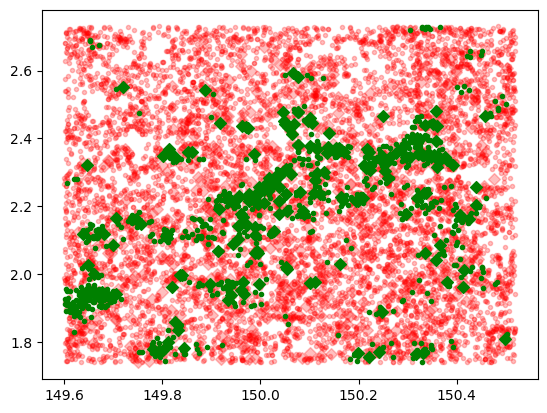

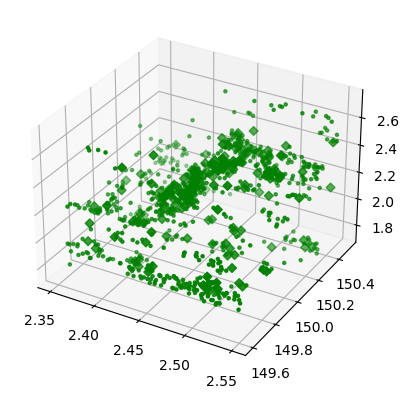

In [9]:
### CHECK DISTRIBUTION OF MEMBER GALAXIES IN HYPERION ###

# Find gals which are in any peak at all
gs = c20s[np.where(c20s[:,-2] >0)]    # spec
gp = c20p[np.where(c20p["sigma_2.0"] >0)] # phot

bs = np.ma.array(c20s, mask=False)
bs.mask[np.where(c20s[:,-2] >0)] = True
bp = np.ma.array(c20p, mask=False)
bp.mask[np.where(c20p["sigma_2.0"] >0)] = True


plt.scatter(bp['ALPHA_J2000'], bp['DELTA_J2000'], c='r', marker='.', alpha=0.25)
plt.scatter(bs[:,4], bs[:,6], c="r", marker="D", alpha=0.25)
plt.scatter(gp['ALPHA_J2000'], gp['DELTA_J2000'], c='g', marker='.')
plt.scatter(gs[:,4], gs[:,6], c="g", marker="D")
plt.show()

fig =plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(bp["lp_zPDF"], bp['ALPHA_J2000'], bp['DELTA_J2000'], c='r', marker='.')
# ax.scatter(bs[:,11], bs[:,4], bs[:,6], c="r", marker="D")
ax.scatter(gp["lp_zPDF"], gp['ALPHA_J2000'], gp['DELTA_J2000'], c='g', marker='.')
ax.scatter(gs[:,11], gs[:,4], gs[:,6], c="g", marker="D")
plt.show()

In [10]:
print("Hyperion Spec-members = ", len(gs))
print("Hyperion Phot-members = ", len(gp))
print()
print("Field Spec-members = ", len(bs))
print("Field Phot-members = ", len(bp))


Hyperion Spec-members =  205
Hyperion Phot-members =  712

Field Spec-members =  675
Field Phot-members =  8784


In [11]:
### Find volume of my cube ###

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
theta_dec = (dec_range[1]-dec_range[0])*np.pi/180 * u.rad
theta_RA  = (ra_range[1]-ra_range[0])*np.pi/180 * u.rad * np.cos(theta_dec)
Omega     = (theta_RA * theta_dec).to(u.steradian).value # get rid of unit
d2        = cosmo.comoving_distance(2.35)
d3        = cosmo.comoving_distance(2.55)
V         = Omega/(4*np.pi) *(cosmo.comoving_volume(2.55) - cosmo.comoving_volume(2.35))
print("Volume of Hyperion Cube =", V)

Volume of Hyperion Cube = 2436313.8003173335 Mpc3


In [12]:
print(peak_vols)

[3786.833, 5631.459, 10158.201000000001, 18107.515, 34266.96799999999, 84565.718, 171698.81299999997]


c:\Users\sikor\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


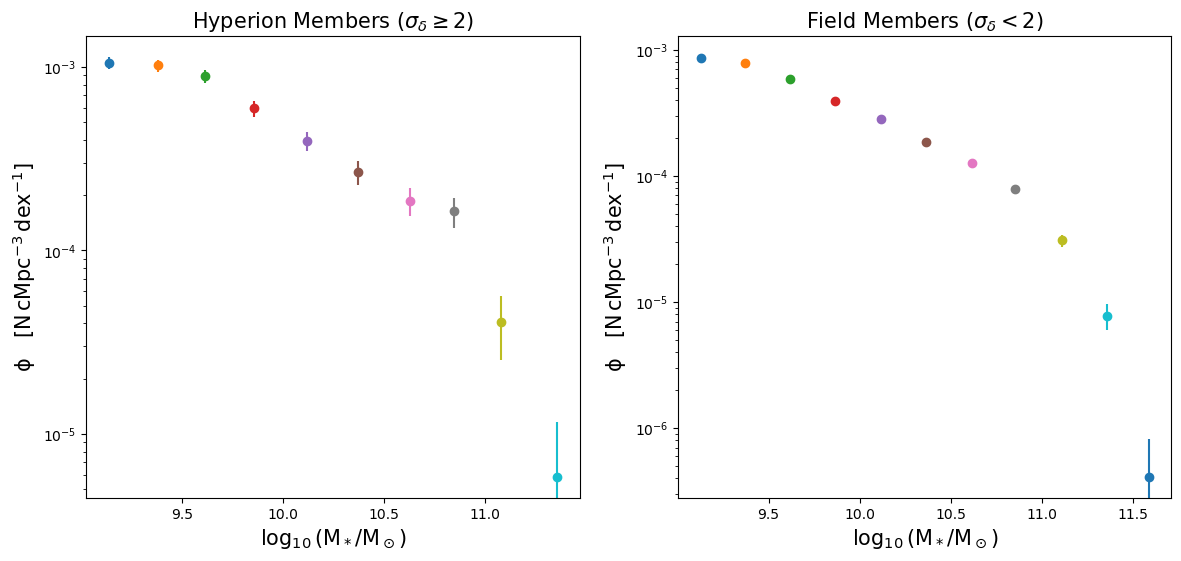

In [13]:
### Make SMF for all Hyperion and Field Members ###


fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,6)

m = 9.0     # Smallest galaxies to plot
m_step = 0.25

while m < 12.5:


    ## Get galaxies in each pop
    s_in = gs[np.where((gs[:,15] >= m) & (gs[:,15] <= m+m_step))]
    s_out = bs[np.where((bs[:,15] >= m) & (bs[:,15] <= m+m_step))]
    p_in = gp[np.where((gp["lp_mass_med"] >= m) & (gp["lp_mass_med"] <= m+m_step) )]
    p_out = bp[np.where((bp["lp_mass_med"] >= m) & (bp["lp_mass_med"] <= m+m_step) )]

    m_in = np.concatenate((s_in[:,15], p_in["lp_mass_med"]))
    m_out = np.concatenate((s_out[:,15], p_out["lp_mass_med"]))

    n_in = len(m_in)/peak_vols[-1]
    n_out = len(m_out)/V.value

    if len(m_in) !=0:

        ax[0].errorbar(np.median(m_in), n_in, yerr=np.sqrt(len(m_in))/peak_vols[-1], marker="o")
    if len(m_out) != 0:
        ax[1].errorbar(np.median(m_out), n_out, yerr=np.sqrt(len(m_out))/V.value, marker="o")



    m += m_step


ax[0].set(yscale="log")
ax[0].set_title(r"Hyperion Members $(\sigma_\delta \geq 2)$", fontsize=15)
ax[0].set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
ax[0].set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

ax[1].set(yscale="log")
ax[1].set_title(r"Field Members $(\sigma_\delta < 2)$", fontsize=15)
ax[1].set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
ax[1].set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()

In [14]:
### Calculate SMF ###
sigs = [2.0, 3.0, 4.0, 5.0]

smf_data = []       # Store the smf data


## Field

m = 9.0     # Smallest galaxies to plot
m_step = 0.25
field_d = []
while m < 12.5:

    ## Get galaxies in each pop

    # s_out = bs[np.where((bs[:,15] >= m) & (bs[:,15] < m+m_step))]

    # p_out = bp[np.where((bp["lp_mass_med"] >= m) & (bp["lp_mass_med"] < m+m_step) )]


    # m_out = np.concatenate((s_out[:,15], p_out["lp_mass_med"]))
    mass_check = bad_masses[0]
    m_out = mass_check[np.where((m<= mass_check) & (mass_check < m+m_step))]

    n_out = len(m_out)/(V.value - peak_vols[-1])


    if n_out != 0:
        field_d.append([np.median(m_out), n_out, np.sqrt(len(m_out))/(V.value - peak_vols[-1])])
    m += m_step


smf_data.append(np.array(field_d))



## Hyperion

for si, sig in enumerate(sigs):

    d_array = []    # Store data for this sigma cutoff as [mass, n, error]

    # # Get galaxies in the sigma bin
    # gs = c20s[np.where(c20s[:,-int(2*si+1)] >0)]    # spec
    # gp = c20p[np.where(c20p[f"sigma_{sig}"] >0)] # phot

    m = 9.0     # Smallest galaxies to plot
    m_step = 0.25

    while m < 12.5:

    #     masses = []
    #     for m_s in gs[:,15]:
    #         if (m <= m_s < m+m_step):
    #             masses.append(m_s)
        
    #     for m_p in gp["lp_mass_med"]:
    #         if (m <= m_p < m+m_step):
    #             masses.append(m_p)
        masses = []
        for m_test in good_masses[si]:
            if (m <= m_test < m+m_step): masses.append(m_test)


        N = len(masses)
        if sig != 5.0:

            v = peak_vols[-int(2*si+1)] - peak_vols[-int(2*si+1)-2]
        else:
            v = peak_vols[0]
        n = N/v
        if N != 0:
            d_array.append(np.array([np.median(masses), n, np.sqrt(N)/v]))

        m += m_step
    
    smf_data.append(np.array(d_array))

smf_data = np.array(smf_data, dtype=object)

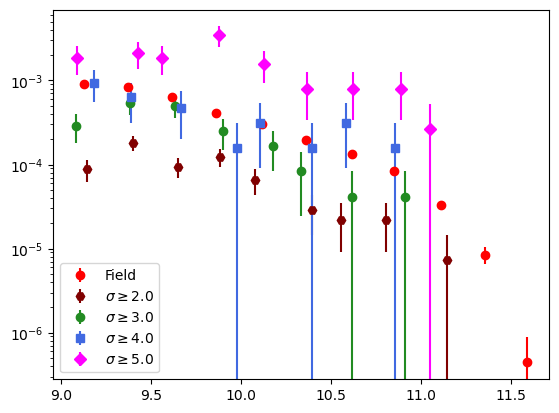

In [15]:
sigs = [2.0, 3.0, 4.0, 5.0]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]


for id, s in enumerate(smf_data):
    l = rf"$\sigma \geq {sigs[id-1]}$" if id !=0 else "Field"
    plt.errorbar(x=s[:,0], y=s[:,1], yerr=s[:,2], c=colors[id], marker=shapes[id], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.show()

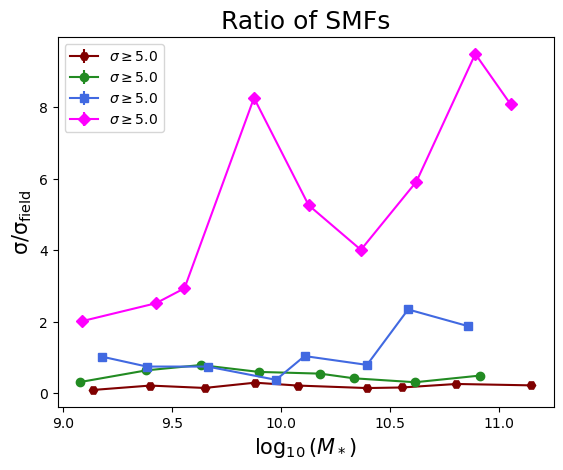

In [16]:
sigs = [2.0, 3.0, 4.0, 5.0]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]


for id, s in enumerate(smf_data):
    if id != 0:
        comp_data = smf_data[0][:len(s[:,0])]
        plt.errorbar(x=s[:,0], y=s[:,1]/comp_data[:,1], yerr=np.sqrt(s[:,2]**2 + comp_data[:,2]**2), c=colors[id], marker=shapes[id], label=rf"$\sigma \geq {sig}$")


plt.legend(loc="upper left")
plt.title("Ratio of SMFs", fontsize=18)
plt.ylabel(r"$\rm \sigma/\sigma_{field}$", fontsize=15)
plt.xlabel(r"$\log_{10}(M_*)$", fontsize=15)
# plt.yscale("log")
plt.show()

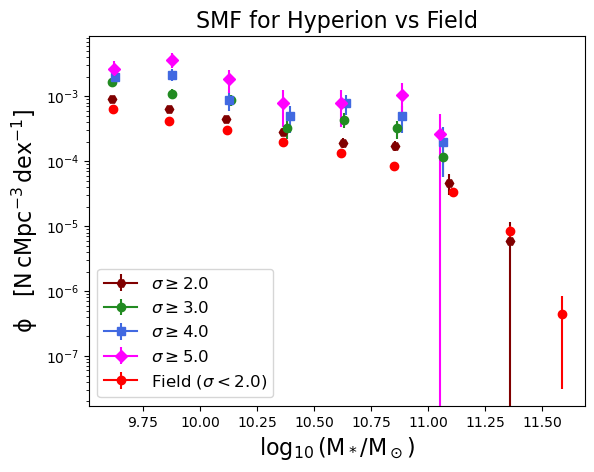

In [17]:
sigs = [2.0, 3.0, 4.0, 5.0]
colors = ["maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["H", "o", "s", "D"]



for si, sig in enumerate(sigs):

    # Get galaxies in the sigma bin
    gs = c20s[np.where(c20s[:,-int(2*si+1)] >0)]    # spec
    gp = c20p[np.where(c20p[f"sigma_{sig}"] >0)] # phot

    m = 9.5     # Smallest galaxies to plot
    m_step = 0.25

    while m < 12.5:

        masses = []
        for m_s in gs[:,15]:
            if (m <= m_s < m+m_step):
                masses.append(m_s)
        
        for m_p in gp["lp_mass_med"]:
            if (m <= m_p < m+m_step):
                masses.append(m_p)

        N = len(masses)
        v = peak_vols[-int(2*si+1)]
        n = N/v

        if N != 0:
            if m == 9.5:
                plt.errorbar(np.median(masses), n, yerr=np.sqrt(N)/v, marker=shapes[si], c=colors[si], label=rf"$\sigma \geq {sig}$")
            else:
                plt.errorbar(np.median(masses), n, yerr=np.sqrt(N)/v, marker=shapes[si], c=colors[si])

        m += m_step


## Field

m = 9.5     # Smallest galaxies to plot
m_step = 0.25

while m < 12.5:

    ## Get galaxies in each pop

    s_out = bs[np.where((bs[:,15] >= m) & (bs[:,15] < m+m_step))]

    p_out = bp[np.where((bp["lp_mass_med"] >= m) & (bp["lp_mass_med"] < m+m_step) )]


    m_out = np.concatenate((s_out[:,15], p_out["lp_mass_med"]))

    n_out = len(m_out)/(V.value - peak_vols[-1])

    if len(m_out) != 0:
        if m == 9.5:
            plt.errorbar(np.median(m_out), n_out, yerr=np.sqrt(len(m_out))/V.value, marker="o", color="red",label=r"Field ($\sigma < 2.0$)" )
        else:
            plt.errorbar(np.median(m_out), n_out, yerr=np.sqrt(len(m_out))/V.value, marker="o", color="red")


    m += m_step


plt.yscale("log")
plt.title(r"SMF for Hyperion vs Field", fontsize=16)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=16)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.show()


### Overdensities

In [18]:
### Make a plot of overdensities of galaxies:

# Combine phot and spec data into (ra,dec,z,stellarmass,overdensity, spec?)
temp_list = []
for p in c20p:
    temp_list.append([p["ALPHA_J2000"], p["DELTA_J2000"],p["lp_zPDF"] ,p["lp_mass_med"], p["OD"], 0])

for s in c20s:
    temp_list.append([s[4], s[6], s[11], s[15], s[32],1])

temp_list = np.array(temp_list, dtype=float)

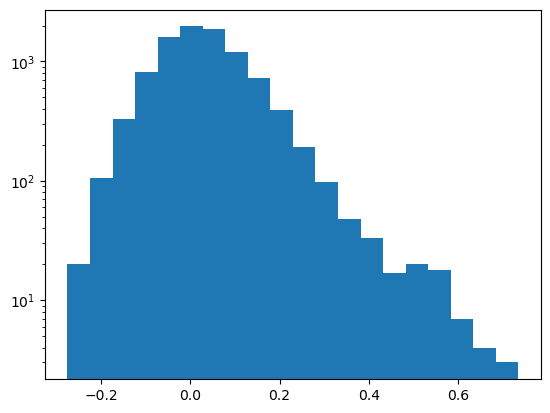

In [19]:
### Histogram of overdensities ###

plt.hist(temp_list[:,-2], bins = 20)
plt.yscale("log")
plt.show()

### Stellar Masses

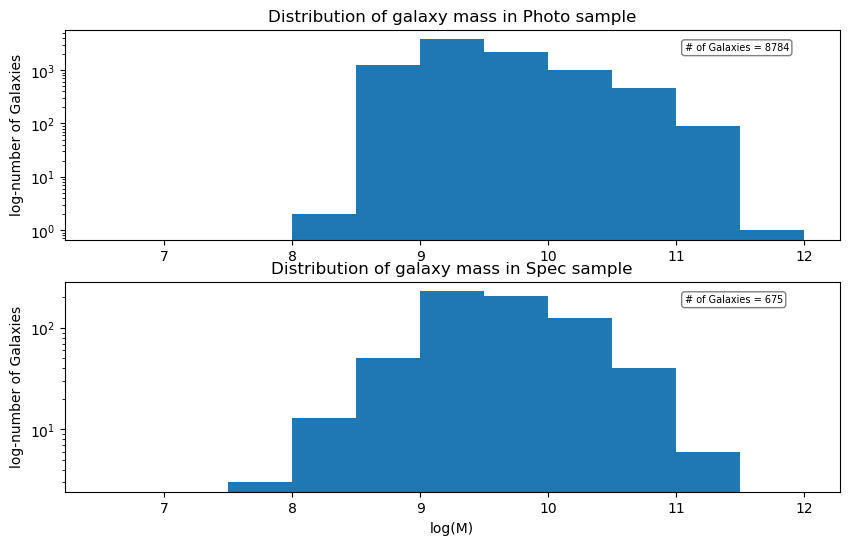

In [20]:
### C20 Phot stellar mass

fig,ax = plt.subplots(2,1)

fig.set_size_inches(10,6)

ax[0].hist(c20p["lp_mass_med"], bins=np.arange(6.5, 12.5, 0.5))
ax[0].set(yscale="log", ylabel="log-number of Galaxies", title="Distribution of galaxy mass in Photo sample")
bbox = dict(boxstyle='round', fc = "white", ec='k', alpha=0.5)
ax[0].text(0.8, 0.9, f"# of Galaxies = {c20p.shape[0]}", fontsize=7,
                    bbox=bbox,transform=ax[0].transAxes)

ax[1].hist(c20s[:,15], bins=np.arange(6.5, 12.5, 0.5))
ax[1].set(yscale="log", ylabel="log-number of Galaxies",xlabel="log(M)", title="Distribution of galaxy mass in Spec sample")
bbox = dict(boxstyle='round', fc = "white", ec='k', alpha=0.5)
ax[1].text(0.8, 0.9, f"# of Galaxies = {c20s.shape[0]}", fontsize=7,
                    bbox=bbox,transform=ax[1].transAxes)

plt.show()